# Latent Dirichlet Allocation - Solutions

In this tutorial we will be working with the transcriptions of general debates at the United Nations from 1970 to 2016. We will try to see whether the fall of the iron curtain changed the debates.

For now, we'll just focus on the representation of the general debeates using various methods.

## Packages

In [1]:
InstallPackages = False
if InstallPackages:
    !pip install pandas
    !pip install numpy
    !pip install scikit-learn
    !pip install spacy
    !pip install gensim
    !pip install seaborn
    !pip install matplotlib

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import spacy
from pprint import pprint

In [3]:
DownloadAdditions = False
if DownloadAdditions:
    spacy.cli.download('en_core_web_sm')

In [4]:
nlp = spacy.load('en_core_web_sm')

## Seed

In [5]:
seed = 42

## Read the Data
Read in the pre-processed 03.1 un-general-debates.csv file and set it to a data frame called df.

In [6]:
df = pd.read_csv('Data/03.1 un-general-debates.csv')

Use info on df

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   session   7507 non-null   int64 
 1   year      7507 non-null   int64 
 2   country   7507 non-null   object
 3   text      7507 non-null   object
 4   document  7507 non-null   object
dtypes: int64(2), object(3)
memory usage: 293.4+ KB


Check the head of ad_data

In [8]:
df.head()

,session,year,country,text,document
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...,indeed pleasure member delegation extend ambas...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",may begin congratulate sir election presidency...
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",mr president particular pleasure behalf delega...
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...,debate fortieth session general assembly four ...
4,44,1989,ZWE,﻿I should like at the outset to express my del...,like outset express delegation satisfaction pl...


## Exercise 1 - Write functions to conduct the Latent Dirichlet Allocation

*Hint:* You may write a function to get the document topics matrix

*Hint:* You may write a function to train the model

*Hint:* You may write a function to build the elbow curve

*Hint:* You may write a function to get the posterior probability of tokens per topics

Get document topics function

In [9]:
def get_document_topics_matrix(statements, num_topics, corpus, model):
    
    """
    
    This function returns the document to topic matrix.
    
    """
    
    get_document_topics = [model.get_document_topics(item) for item in corpus]
    
    document_topics = pd.DataFrame(columns=['topic_' + str(i) for i in range(1,num_topics+1)],index=range(0,len(statements)))

    d=0
    g=0
    for r in range(0, len(statements)):
        if statements[r]!="":
            document_topics[d:(d+1)] = 0
            for t in (range(0, len(get_document_topics[g]))):
                document_topics.loc[(r):(r),str("topic_"+str((get_document_topics[g][t][0]+1)))]=get_document_topics[g][t][1]  
            g=g+1

        d=d+1
    
    return document_topics

train the model

In [10]:
def train_lda_model(statements, num_topics, trim):
    
    """
    
    This function trains the LDA.
    
    """
    
    docs = []
    for statement in statements:
        doc = nlp(statement)
        tokens = [t.text.lower() for t in doc]
        
        if tokens:
            docs.append(tokens)
    
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=10, no_above=trim)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    temp = dictionary[0]
    id2word = dictionary.id2token
    
    chunksize = 1500
    passes = 100
    iterations = 1000
    eval_every = None
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state = seed
    )
    
    
    return model, corpus, id2word

elbow curve function

In [11]:
def elbow_topics(statements, maxnumber_topics, trim):
    
    """
    
    This function is used to get the optimal number of topics in an LDA.
    
    """
    
    number_topics = range(1, maxnumber_topics + 1) 
    
    model_topics = [train_lda_model(statements, num_topics = i, trim = trim)[0] for i in number_topics]
    corpus_topics = [train_lda_model(statements, num_topics = i, trim = trim)[1] for i in number_topics]
    
    perplexityscores = [model_topics[i].log_perplexity(corpus_topics[i]) for i in range(len(model_topics))]
    coherencescores = [CoherenceModel(model=model_topics[i], corpus=corpus_topics[i], coherence='u_mass',topn = 10).get_coherence() for i in range(len(model_topics))]
    
    return pd.concat([pd.DataFrame({'Coherence': coherence_score})*(-1), pd.DataFrame({'Topics': range(1, maxnumber_topics + 1)})], axis=1) 
    
    print(perplexityscores)
    print(coherencescores)    
    
    plt.locator_params(axis='y', nbins=12)
    plt.locator_params(axis='x', nbins=maxnumber_topics + 1)
    
    plt.plot(number_topics, coherencescores)
    plt.xlabel('Number of Topics')
    plt.ylabel('coherencescores')
    plt.title('Coherence Score')
    plt.show()
    
    plt.plot(number_topics, perplexityscores)
    plt.xlabel('Number of Topics')
    plt.ylabel('perplexityscores')
    plt.title('Perplexity Score')
    plt.show()

Posterior probability of tokens per topics

In [12]:
def tokens_per_topics(model):
    
    """
    
    This function is used to get the posterior probability of tokens per topics.
    
    """
    
    topics = model.show_topics(formatted=False)
    
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight])
    
    
    return pd.DataFrame(out, columns=['word', 'topic', 'probability'])  
    

## Exercise 2 - Conduct the Latent Dirichlet Allocation

Not it's time to conduct the Latent Dirichlet Allocation.

In [13]:
#define the trim parameter
trim_num = 0.95

In [14]:
#coherence_score = elbow_topics(data['document'], maxnumber_topics = 100, trim = trim_num)

In [15]:
#coherence_score

In [16]:
#set the number of topics
true_k = 10

In [17]:
#train model
model, corpus, id2word = train_lda_model(statements = df['document'], num_topics = true_k, trim = trim_num)

In [18]:
# print the keywords per topic
pprint(model.print_topics(num_words=10))

[(0,
  '0.014*"burundi" + 0.013*"government" + 0.011*"2001" + 0.010*"continue" + '
  '0.007*"war" + 0.007*"delegation" + 0.006*"organization" + 0.006*"term" + '
  '0.005*"resolution" + 0.005*"process"'),
 (1,
  '0.011*"africa" + 0.009*"economic" + 0.007*"community" + 0.007*"south" + '
  '0.007*"problem" + 0.006*"african" + 0.006*"organization" + 0.006*"continue" '
  '+ 0.006*"develop" + 0.006*"session"'),
 (2,
  '0.007*"must" + 0.007*"global" + 0.006*"human" + 0.006*"reform" + '
  '0.006*"need" + 0.005*"council" + 0.005*"challenge" + 0.005*"continue" + '
  '0.005*"community" + 0.005*"develop"'),
 (3,
  '0.012*"terrorism" + 0.012*"kuwait" + 0.009*"iraq" + 0.007*"terrorist" + '
  '0.007*"resolution" + 0.007*"government" + 0.006*"palestinian" + '
  '0.005*"humanitarian" + 0.005*"act" + 0.005*"convention"'),
 (4,
  '0.013*"azerbaijan" + 0.011*"conflict" + 0.009*"cooperation" + '
  '0.008*"community" + 0.008*"organization" + 0.007*"global" + 0.007*"region" '
  '+ 0.007*"economic" + 0.007*"t

In [19]:
#tokens_per_topics_probability = tokens_per_topics(model)

In [20]:
#tokens_per_topics_probability

In [21]:
#get document topics from model
#pd.set_option('display.max_rows', None)
document_topics = get_document_topics_matrix(statements = df['document'], num_topics = true_k, corpus = corpus, model = model)
print(document_topics)

       topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0            0  0.528248  0.224214         0         0  0.010069  0.111828   
1            0  0.210945  0.378441         0         0         0  0.118002   
2            0  0.705527   0.04022         0         0         0  0.157682   
3            0  0.371041  0.064798         0         0         0  0.491741   
4            0  0.576019  0.110184         0         0  0.056622  0.201706   
...        ...       ...       ...       ...       ...       ...       ...   
7502         0         0         0         0  0.998481         0         0   
7503  0.049498         0         0         0         0         0         0   
7504  0.999185         0         0         0         0         0         0   
7505         0         0         0  0.983791  0.015093         0         0   
7506  0.101411         0         0  0.897809         0         0         0   

       topic_8   topic_9  topic_10  
0     0.011738   0.11373  

## Exercise 3 - Vizualize the Latent Dirichlet Allocation

Now, it's time to visualize the Latent Dirichlet Allocation results.

Visualize the divergence between the topics using, e.g., the Jensen-Shannon divergence

Function to plot differences between topics

In [22]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    
    """
    Function to plot difference between models. Uses matplotlib as the backend.
    
    """
    
    fig, ax = plt.subplots(figsize=(8, 4))
    data = ax.imshow(mdiff, cmap='RdBu', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    
    topic = topic = ["{}".format(i) for i in range(1, len(mdiff)+1)]
    ax.set_xticks(np.arange(len(topic)), labels=topic)
    ax.set_yticks(np.arange(len(topic)), labels=topic)
    
    ax.set_xlabel('Topic')
    ax.set_ylabel('Topic')
    
    #plt.savefig("Figures/Figure_LDATopicDifferences"+ str(len(mdiff)) + ".pdf", bbox_inches='tight', dpi=300)

plot differences between topics

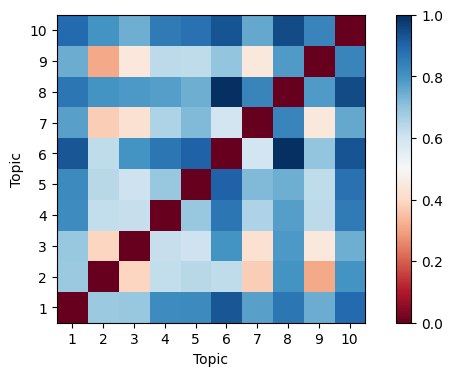

In [23]:
mdiff, annotation = model.diff(model, distance='jensen_shannon', num_words=10)
plot_difference_matplotlib(mdiff, title="", annotation=annotation)

## Exercise 4 - Add topics over documents to dataframe and visualize the topics over time

Add topics over documents to Data Frame

In [24]:
df = pd.concat([df,document_topics], axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   session   7507 non-null   int64 
 1   year      7507 non-null   int64 
 2   country   7507 non-null   object
 3   text      7507 non-null   object
 4   document  7507 non-null   object
 5   topic_1   7507 non-null   object
 6   topic_2   7507 non-null   object
 7   topic_3   7507 non-null   object
 8   topic_4   7507 non-null   object
 9   topic_5   7507 non-null   object
 10  topic_6   7507 non-null   object
 11  topic_7   7507 non-null   object
 12  topic_8   7507 non-null   object
 13  topic_9   7507 non-null   object
 14  topic_10  7507 non-null   object
dtypes: int64(2), object(13)
memory usage: 879.9+ KB


In [30]:
#calculate the mean
yearlyMean = df.groupby(['year'])['topic_9'].mean().reset_index()

In [31]:
yearlyMean

,year,topic_9
0,1970,0.286984
1,1971,0.309529
2,1972,0.30671
3,1973,0.29882
4,1974,0.252097
5,1975,0.31858
6,1976,0.285298
7,1977,0.261463
8,1978,0.25747
9,1979,0.22082


Text(0, 0.5, 'Nuclear weapon topic')

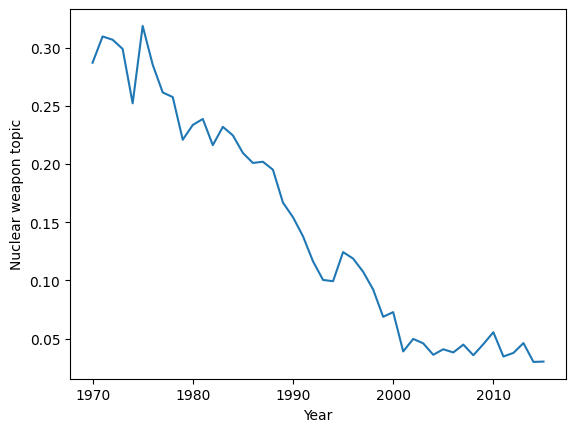

In [33]:
fig, ax = plt.subplots()
ax.plot(yearlyMean['year'], yearlyMean['topic_9'])
ax.set_xlabel('Year')
ax.set_ylabel('Nuclear weapon topic')
#plt.savefig("Figures/Figure_TopicTime"+ str(len(mdiff)) + ".pdf", bbox_inches='tight', dpi=300)

## Exercise 5 - Save the Data Frame

Save the data as 05.1 un-general-debates

In [29]:
#excelfilename = "Data/05.1 un-general-debates.csv"
#df.to_csv(excelfilename,index=False)